In [1]:
%config Completer.use_jedi = False 
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import PolynomialFeatures   
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
# Read tha data
data = pd.read_csv("European_Ski_Resorts.csv")
data.head(5)

,Unnamed: 0,Resort,Country,HighestPoint,LowestPoint,DayPassPriceAdult,BeginnerSlope,IntermediateSlope,DifficultSlope,TotalSlope,Snowparks,NightSki,SurfaceLifts,ChairLifts,GondolaLifts,TotalLifts,LiftCapacity,SnowCannons
0,1,Alpendorf (Ski amedé),Austria,1980,740,52,30,81,4,115,Yes,No,22,16,11,49,75398,600
1,2,Soldeu-Pas de la Casa/​Grau Roig/​El Tarter/​C...,Andorra,2640,1710,47,100,77,33,210,Yes,Yes,37,28,7,72,99017,1032
2,3,Oberau (Wildschönau),Austria,1130,900,30,1,0,1,2,No,No,2,0,0,2,1932,0
3,4,Dachstein West,Austria,1620,780,42,15,33,3,51,Yes,Yes,25,8,3,36,32938,163
4,5,Rosa Khutor,Southern Russia,2320,940,22,30,26,21,77,Yes,No,6,11,10,27,49228,450


In [3]:
# Drop the unnecessary columns and mix the highest and the lowest point to a single "height difference" -column

data.drop(columns=['Unnamed: 0','BeginnerSlope','IntermediateSlope','DifficultSlope','Snowparks',
                 'NightSki','SurfaceLifts','ChairLifts','GondolaLifts','TotalLifts','SnowCannons'],inplace=True)

data.columns =['name','country','highpoint','lowpoint','price','slopes','lift capacity']
hd_column = data['highpoint'].astype(int) - data['lowpoint'].astype(int)
data.insert(2,"height difference",hd_column)
data.drop(columns=['lowpoint','highpoint'],inplace=True)
data.head(5)

,name,country,height difference,price,slopes,lift capacity
0,Alpendorf (Ski amedé),Austria,1240,52,115,75398
1,Soldeu-Pas de la Casa/​Grau Roig/​El Tarter/​C...,Andorra,930,47,210,99017
2,Oberau (Wildschönau),Austria,230,30,2,1932
3,Dachstein West,Austria,840,42,51,32938
4,Rosa Khutor,Southern Russia,1380,22,77,49228


In [4]:
# Calculate how many different countries are in the dataset

countries = data['country']
amount = 0
mentioned = []
for country in countries:
    if country not in mentioned:
        amount = amount + 1
        mentioned.append(country) 

print(amount)
mentioned[0:4]

# Calculate the average price of the day pass by country
# This determines the differences between prices between countries

countries_and_prices = {}
for country in mentioned:
    mentions = 0
    price = 0
    index = 0
    for c in countries:
        if country == c:
            mentions = mentions + 1
            price = price + data['price'][index]
        index = index + 1
    average = price/mentions
    countries_and_prices[country] = average
    
descending_countries_and_prices = dict(sorted(countries_and_prices.items(), key=lambda item: item[1], reverse=True))

27


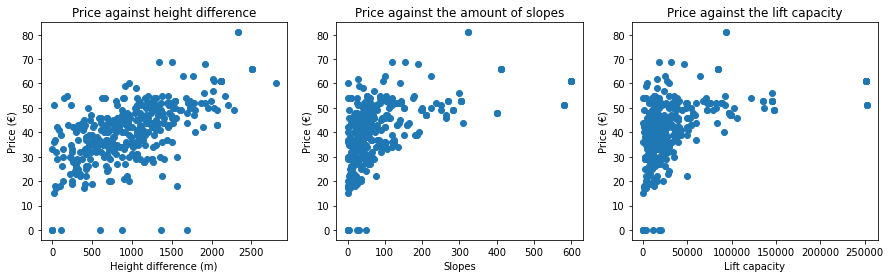

In [5]:
# Visualize data by plotting the label values against different feature values 

fig, features = plt.subplots(1, 3, figsize=(15,4))

features[0].scatter(data['height difference'],data['price']);
features[0].set_xlabel("Height difference (m)")
features[0].set_ylabel("Price (€)")
features[0].set_title("Price against height difference")

features[1].scatter(data['slopes'],data['price']);
features[1].set_xlabel("Slopes")
features[1].set_ylabel("Price (€)")
features[1].set_title("Price against the amount of slopes")

features[2].scatter(data['lift capacity'],data['price']);
features[2].set_xlabel("Lift capacity")
features[2].set_ylabel("Price (€)")
features[2].set_title("Price against the lift capacity")

plt.show()



Text(0.5, 1.0, 'Average price in each country')

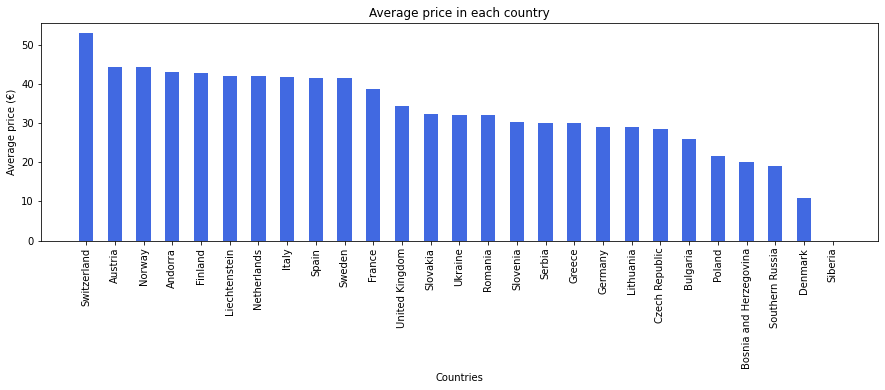

In [6]:
countries_descending = list(descending_countries_and_prices.keys())
prices_descending = list(descending_countries_and_prices.values())

fig = plt.figure(figsize=(15,4))
plt.bar(countries_descending,prices_descending,color = 'royalblue',width = 0.5);
plt.xticks(rotation = 90)
plt.xlabel("Countries")
plt.ylabel("Average price (€)")
plt.title("Average price in each country")

In [11]:
# Create the feature and label matrices

X_tot = np.transpose(np.array([data['slopes'],data['height difference']]))
y_tot = np.transpose(np.array([data['price']]))

print(X_tot.shape,y_tot.shape)

# Split test set out of the data
X,X_test,y,y_test = train_test_split(X_tot,y_tot,test_size = 0.2,random_state = 3)

# Split the remaining data into training and validation set with kfold
k = 4

kf = KFold(n_splits=k, shuffle = True, random_state = 1)
lin_regr = LinearRegression()

val_errors = []
tr_errors = []
test_errors = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    lin_regr.fit(X_train,y_train) # Apply linear regression
    y_train_pred = lin_regr.predict(X_train) #Predict training values
    y_val_pred = lin_regr.predict(X_val) # Predict validation values
    y_test_pred = lin_regr.predict(X_test) # Predict test values
    
    tr_error = mean_squared_error(y_train_pred,y_train) # Training error
    tr_errors.append(tr_error)
    
    val_error = mean_squared_error(y_val_pred,y_val) # Validation error
    val_errors.append(val_error)
    
    test_error = mean_squared_error(y_test_pred,y_test) # Test error
    test_errors.append(test_error)
    
average_tr_error = sum(tr_errors)/k
average_val_error = sum(val_errors)/k
average_test_error = sum(test_errors)/k
print('Average training error: ',average_tr_error)
print('Average validation error: ',average_val_error)
print('Average test error: ',average_test_error)


(376, 2) (376, 1)
Average training error:  96.82494481707741
Average validation error:  98.769862385479
Average test error:  82.21050370544866


In [12]:
# Same steps with polynomial regression

degrees = [3,5,7]

for degree in degrees:
    
    tr_errors = []
    val_errors = []
    test_errors = []
    
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        pln = PolynomialFeatures(degree = degree)
        lin_regr = LinearRegression(fit_intercept = False)
        
        X_train_pln = pln.fit_transform(X_train) # Transform X-values to polynomial values
        lin_regr.fit(X_train_pln,y_train) # Apply linear regression to transformed values
        
        y_pred_train = lin_regr.predict(X_train_pln)
        tr_error = mean_squared_error(y_pred_train,y_train) # Calculate the training error
        
        X_val_pln = pln.transform(X_val)
        y_pred_val = lin_regr.predict(X_val_pln)
        val_error = mean_squared_error(y_pred_val,y_val) # Calculate the validation error
        
        X_test_pln = pln.transform(X_test)
        y_pred_test = lin_regr.predict(X_test_pln)
        test_error = mean_squared_error(y_pred_test,y_test) # Calculate the test error
        
        tr_errors.append(tr_error)
        val_errors.append(val_error)
        test_errors.append(test_error)

    average_tr_error = sum(tr_errors)/k
    average_val_error = sum(val_errors)/k
    average_test_error = sum(test_errors)/k
    print('(Degree: ',degree,')')
    print('Average training error: ', average_tr_error)
    print('Average validation error: ', average_val_error)
    print('Average test error: ',average_test_error)



(Degree:  3 )
Average training error:  87.80918128382844
Average validation error:  96.8576028389446
Average test error:  79.04191637469536
(Degree:  5 )
Average training error:  94.56963262402606
Average validation error:  8172.607401532092
Average test error:  201.9304303574885
(Degree:  7 )
Average training error:  45632.416652723245
Average validation error:  18971944.236774042
Average test error:  881064.2446073884
